# RSA

In [1]:
%matplotlib inline

In [2]:
import itertools
import multiprocessing
import os
import pickle

import matplotlib.colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin
import seaborn as sns
import scipy.stats
from scipy.spatial.distance import pdist, squareform
from numba import njit

from utils import (
    BIDS_ROOT,
    find_time_idxs,
    get_erps_by_dict,
    _kendall_tau_a,
    extract_sample_frequencies,
    spm_orth,
    prep_epochs,
)

# Define analysis parameters

In [3]:
# IO: Where to find the data
# Where to find epochs
fname_epo_template = os.path.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_epochs-epo.fif.gz"
)


# Pack all names in a dict
name_templates = dict()
name_templates["epochs"] = fname_epo_template

In [4]:
# preprocessing settings 
preproc_settings = {
    'crop': (0.6, 1.6),
    'tshift': -0.8,
    'smooth': 250,
    'baseline': (None, 0),
}

In [5]:
# Get an ERP for extracting times array
# it's the same for all ERPs and will be used below
tmp = get_erps_by_dict({'all': list()}, name_templates, [1],
                       **preproc_settings)
times = tmp['all'][0].times

# Neurometrics

## settings and func defs

In [7]:
# Where the RSA results are stored
results_folder = "cv-False_flip-False_rsa-pearson_dist-euclidean_half-both_"
results_folder += "exclude-Identity_mnn-FalseFalseFalse_ec-False_"
results_folder += "c-(0.6, 1.6)t--0.8s-150b-(None, 0)s-True_outcome"

rsa_results_path = os.path.join(
    BIDS_ROOT,
    "derivatives",
    "rsa_9x9",
    results_folder,
)

In [8]:
# Setup
# -----
# Define constants
subjects = np.arange(1, 41)
numbers = np.arange(1, 10)
tasks = ("AF", "AV", "YF", "YV")

rdms_folder_template = os.path.join(
    rsa_results_path, "single_subj_plots", "sub-{:02}_task-{}_rdm_times.npy"
)

# Read behavioral data to get mapping which subj was in which task
beh_fname = "behavioral_data.csv"
beh_fpath = os.path.join(BIDS_ROOT, "code", beh_fname)
df = pd.read_csv(beh_fpath)

# Determine based on what time window in EEG-RDM to calculate correlations
custom_window = (0.3, 0.6)
max_cluster = find_time_idxs(custom_window, times)

# numerical distance
# rescale numbers 1 to 9 to range -1, 1
numbers_rescaled = np.interp(numbers, (numbers.min(), numbers.max()), (-1, +1))

# lower triangle indices for later extracting vector from RDMs
lower_triangle_idx = np.tril_indices(numbers.shape[0], k=-1)

# method for correlating model-RDM and EEG-RDM
corr_method = "pearson"
do_orth = True
orth_demean = True
orth_other_model = False  # if True, orth sfreq, num, ext ... else only sfreq num/ext
wilcoxon = False
relative_to_b0_k1 = True

# granularity of bias and kappa parameters
n = 300

# bias and kappa param values to use
_b = 0.75
biases = np.linspace(-_b, _b, n)
kappas = np.linspace(0.5, 10.0, n)
bias_kappa_combis = list(itertools.product(biases, kappas))

biases = np.unique(np.array(bias_kappa_combis)[:, 0])
kappas = np.unique(np.array(bias_kappa_combis)[:, 1])
bias_0_idx = (np.abs(biases - 0)).argmin()
kappa_1_idx = (np.abs(kappas - 1)).argmin()

# How many jobs to run in parallel
NJOBS = multiprocessing.cpu_count() - 1

# Whether or not to save plots
plotsave = True

In [224]:
try:
    eeg_rdms
    assert eeg_rdms.shape == (40, 4, 9, 9)
    assert eeg_rdms.flat[1] == 4.553910558275579,  "item in eeg_rdms unexpected"
    print("EEG-RDMs already loaded.")
except NameError:
    # Read EEG-RDMs
    # -------------
    # Go over subjects and tasks
    # save RDMs in a large array for later averaging
    # eeg_rdms is (40 x 4 x 9 x 9) containing the RDMs averaged over the
    # max_cluster window ... half of the arrays are NaN, because each
    # of the 40 subjs only had 2, instead of 4 tasks
    eeg_rdms = np.full((len(subjects), len(tasks), 9, 9), np.nan)
    did_not_find = 0
    for isubj, subj in enumerate(subjects):

        for itask, task in enumerate(tasks):

            fname = rdms_folder_template.format(subj, task)
            if not os.path.exists(fname):
                did_not_find += 1
                continue

            rdm_times = np.load(fname)
            rdm_average = np.mean(rdm_times[..., max_cluster], axis=-1)
            eeg_rdms[isubj, itask, ...] = rdm_average

    # sanity check: 2 of 4 tasks for each subj should be skipped
    if did_not_find != len(subjects) * 2:
        raise ValueError(f"unexpected number of rdm_times.npy found: {did_not_find}")

EEG-RDMs already loaded.


In [225]:
# produce model-RDMs (numberline, extremity) based on "biased and kappaed" numbers
# --------------------------------------------------------------------------------
@njit
def eq1(X, bias, kappa):
    """See equation 1 from Spitzer et al. 2017, Nature Human Behavior."""
    dv = np.sign(X + bias) * (np.abs(X + bias) ** kappa)
    return dv


def produce_model_rdms(model_to_use, bias_kappa_combis):
    """Using different combinations of bias and kappa, produce model RDMs.

    Scale numbers from 1 to 9 first to a range -1 to 1, and then distort them
    based on equation 1 from Spitzer et al. 2017 (NHB), using different
    combinations of bias and kappa parameters. The build an RDM from each
    resulting set of distorted numbers: For numberline, just take the numbers
    as they are - and for extremity, take the absolute value of the numbers
    (see Notes).

    Parameters
    ----------
    model_to_use : {"numberline", "extremity"}
        Which model RDMs to produce.
    bias_kappa_combias : list of tuple of len 2
        Each tuple in the list is a unique combination of (bias, kappa).

    Returns
    -------
    model_rdms : np.ndarray, shape(9, 9, len(bias_kappa_combis))
        The model RDMs for either numberline or extremity.

    Notes
    -----
    For extremity, we take the absolute of the distorted values, because it
    corresponds to how we calculate extremity on the non-re-scaled,
    non-distorted values 1, 2, ..., 9: first center them around zero, and
    then take the absolute:

    ``np.abs(np.arange(1, 10) - np.median(np.arange(1, 10)))``

    In our steps we already centered on zero through rescaling to -1, 1.

    See also
    --------
    eq1

    """
    numbers = np.arange(1, 10)
    numbers_rescaled = np.interp(numbers, (numbers.min(), numbers.max()), (-1.0, +1.0))

    model_rdms = np.full(
        (
            len(numbers),
            len(numbers),
            len(bias_kappa_combis),
        ),
        np.nan,
    )
    for i, (bias, kappa) in enumerate(bias_kappa_combis):

        # Calculate DV for each rescaled number given bias and kappa
        dv_vector = eq1(numbers_rescaled, bias, kappa)

        # If we want to produce extremity RDMs, absolute, see Notes in docstr
        if model_to_use == "extremity":
            dv_vector = np.abs(dv_vector)

        else:
            assert model_to_use == "numberline", "unknown `model_to_use`."

        # Calculate RDM based on DVs
        arrs = []
        for dv in dv_vector:
            arrs.append(np.abs(dv_vector - dv))
        model_rdms[..., i] = np.stack(arrs, axis=0)

    # Sanity check: No NaNs
    assert not np.isnan(model_rdms).any()
    return model_rdms

In [226]:
# model RDMs (constants)
NUMBERLINE_RDMS = produce_model_rdms("numberline", bias_kappa_combis)
EXTREMITY_RDMS = produce_model_rdms("extremity", bias_kappa_combis)

In [227]:
def corr_model_and_eeg_rdms(
    subject,
    itask,
    model_rdms,
    eeg_rdms,
    corr_method,
    bias_kappa_combis,
    lower_triangle_idx,
    df,
    do_orth,
    orth_demean,
    orth_other_model,
):
    """Correlate model-RDMs and EEG-RDMs per task and subject.

    Parameters
    ----------
    subject : int
        The subject ID (1 to 40).
    itask : int | "all"
        Index into the task array ``('AF', 'AV', 'YF', 'YV')``. Not that
        not all subjects have performed all tasks. This needs to be handled
        outside of this function. Only pass subject-task combinations that
        do exist in the data. If "all", the `eeg_rdms` must be of
        shape (40, 9, 9).
    model_rdms : np.ndarray, shape(9, 9, n)
        All ``n`` model RDMs (9 by 9) that were created based on ``eq1``.
    eeg_rdms : np.ndarray, shape(40, 4, 9, 9)
        All EEG RDMs (9 by 9), for all subjects (40), and tasks (4). Contains
        NaN values for some slices, because not all subjects performed all
        tasks. These RDMs are averaged over some time period.
    corr_method : str
        How to correlate the model and EEG RDMs. Must be one of
        [pearson, spearman, kendall_a, kendall_b].
    bias_kappa_combis : list of tuple
        Each tuple in the list contains (bias, kappa) floats.
    lower_triangle_idx : np.ndarray
        Indices to extract the lower triangle from a 9 by 9 matrix.
    df : pandas.DataFrame
        The behavioral data.
    do_orth : bool
        Whether or not to orthogonalize model.
    orth_demean : bool
        Whether or not to demean each column before orthogonalization.
    orth_other_model : bool
        Whether to orthogonalize sfreq, numberline, extremity. If False,
        only orthogonalize sfreq with either numberline or extremity.

    Returns
    -------
    subject : int
        The subject.
    itask : int
        The task index into the tuple ("AF", "AV", "YF", "YV").
    coefs : np.ndarray, shape(n, n)
        The correlation coefficients for each bias/kappa combination. The
        bias parameters are on the x-axis of the 2D array (increasing left
        to right), the kappa parameters are on the y-axis of the 2D array
        (increasing top to bottom). See `bias_kappa_combis` for the parameter
        values (``biases=np.unique(np.array(bias_kappa_combis)[:, 0])``,
        ``kappas=np.unique(np.array(bias_kappa_combis)[:, 1])``)
    pvals : np.ndarray, shape(n, n)
        The two-tailed p-value corresponding to each correlation coefficient.
    """
    # Get sampling frequency model vector for this subj and task
    tasks = ("AF", "AV", "YF", "YV")
    _df = df[df["subject"] == subject]
    if isinstance(itask, str):
        # we are working on "all" tasks at once
        assert itask == "all", "itask must be int, or 'all'."
        assert eeg_rdms.shape == (40, 9, 9), "if itask is 'all', pass all eeg_rdms."
    else:
        # we are working on a specific task
        # make further sub-selection into task
        _df = _df[_df["task"] == tasks[itask]]

    sfreqs = extract_sample_frequencies(_df, with_sides=False)

    # normalize to be in -1, 1 range
    sfreqs = np.interp(sfreqs, (sfreqs.min(), sfreqs.max()), (-1, +1))

    # build RDM
    arrs = []
    for sf in sfreqs:
        arrs.append(np.abs(sfreqs - sf))

    # extract vector
    mod_sfreq = np.stack(arrs, axis=0)[lower_triangle_idx].flatten()
    if orth_demean:
        mod_sfreq -= mod_sfreq.mean()

    # ----------------------------
    # prep coef and pval arrays
    coefs = np.full(len(bias_kappa_combis), np.nan)
    pvals = np.full(len(bias_kappa_combis), np.nan)

    # get data (EEG)
    if itask == "all":
        assert eeg_rdms.shape == (40, 9, 9)
        eeg_rdm_vector = eeg_rdms[subject - 1, ...]
    else:
        assert eeg_rdms.shape == (40, 4, 9, 9)
        eeg_rdm_vector = eeg_rdms[subject - 1, itask, ...]

    eeg_rdm_vector = eeg_rdm_vector[lower_triangle_idx].flatten()

    # Get data (model) per bias-kappa combination and correlate with EEG
    for icombi in range(len(bias_kappa_combis)):
        mod_rdm_vector = model_rdms[..., icombi][lower_triangle_idx].flatten()

        # Get the other rdm vector (either numberline or extremity)
        mod_other_num = NUMBERLINE_RDMS[..., icombi][lower_triangle_idx].flatten()
        mod_other_ext = EXTREMITY_RDMS[..., icombi][lower_triangle_idx].flatten()

        if np.array_equal(mod_rdm_vector, mod_other_num):
            mod_other = mod_other_ext
        elif np.array_equal(mod_rdm_vector, mod_other_ext):
            mod_other = mod_other_num
        else:
            raise ValueError("mod_rdm_vector not equivalent to either num or ext.")

        # orthogonalize recursively
        if do_orth:
            prev_shape = mod_rdm_vector.shape

            if orth_demean:
                # mean-center first
                mod_other -= mod_other.mean()
                # mod_sfreq is demeaned out of the loop (see above)
                mod_rdm_vector -= mod_rdm_vector.mean()

            # last column is orthed.
            if orth_other_model:
                vecs = [
                    mod_other.reshape(-1, 1),
                    mod_sfreq.reshape(-1, 1),
                    mod_rdm_vector.reshape(-1, 1),
                ]
            else:
                vecs = [
                    mod_sfreq.reshape(-1, 1),
                    mod_rdm_vector.reshape(-1, 1),
                ]
            X = np.hstack(vecs)
            assert X.shape[-1] == len(vecs), "columns should be RDM types"
            X_orth = spm_orth(X)

            # done with orth:
            mod_rdm_vector = X_orth[:, -1].reshape(prev_shape)

        if np.all(mod_rdm_vector == mod_rdm_vector[0]):
            _task = "all" if itask == "all" else tasks[itask]
            print(
                f"equal at {icombi}, {bias_kappa_combis[icombi]}, {subject}, {_task}: {mod_rdm_vector}\n"
            )

        if corr_method == "pearson":
            coef, pval = scipy.stats.pearsonr(eeg_rdm_vector, mod_rdm_vector)
        elif corr_method == "spearman":
            coef, pval = scipy.stats.spearmanr(eeg_rdm_vector, mod_rdm_vector)
        elif corr_method == "kendall_a":
            coef = _kendall_tau_a(eeg_rdm_vector, mod_rdm_vector)
            # no pvals implemented in _kendall_tau_a
            pval = np.nan
        elif corr_method == "kendall_b":
            coef, pval = scipy.stats.kendalltau(eeg_rdm_vector, mod_rdm_vector)
        else:
            raise ValueError(f"Unexpected corr_method: {corr_method}")

        coefs[icombi] = coef
        pvals[icombi] = pval

    # Reshape into maps and return
    n = int(np.sqrt(len(bias_kappa_combis)))
    coefs = coefs.reshape(n, n).T
    pvals = pvals.reshape(n, n).T

    return subject, itask, coefs, pvals

In [228]:
def generate_coef_maps(
    tasks,
    df,
    model_rdms,
    eeg_rdms,
    corr_method,
    bias_kappa_combis,
    lower_triangle_idx,
    do_orth,
    orth_demean,
    orth_other_model,
    NJOBS,
    relative_to_b0_k1,
    bias_0_idx,
    kappa_1_idx,
):
    """Generate coef_map and pval_mamp_subjs."""
    # Prepare all input combinations for multiprocessing.Pool.starmap
    if isinstance(tasks, str):
        assert tasks == "all"
        assert eeg_rdms.shape == (40, 9, 9)
        param_combis = []
        subjects = df["subject"].unique()
        for subject in subjects:
            params = dict(
                subject=subject,
                itask="all",
                model_rdms=model_rdms,
                eeg_rdms=eeg_rdms,
                corr_method=corr_method,
                bias_kappa_combis=bias_kappa_combis,
                lower_triangle_idx=lower_triangle_idx,
                df=df,
                do_orth=do_orth,
                orth_demean=orth_demean,
                orth_other_model=orth_other_model,
            )
            param_combis.append(list(params.values()))
    else:
        assert eeg_rdms.shape == (40, 4, 9, 9)
        param_combis = []
        for itask, task in enumerate(tasks):
            subjects = df[df["task"] == task]["subject"].unique()
            for subject in subjects:
                params = dict(
                    subject=subject,
                    itask=itask,
                    model_rdms=model_rdms,
                    eeg_rdms=eeg_rdms,
                    corr_method=corr_method,
                    bias_kappa_combis=bias_kappa_combis,
                    lower_triangle_idx=lower_triangle_idx,
                    df=df,
                    do_orth=do_orth,
                    orth_demean=orth_demean,
                    orth_other_model=orth_other_model,
                )
                param_combis.append(list(params.values()))

    # Process inputs in parallel
    with multiprocessing.Pool(NJOBS) as pool:
        results = pool.starmap(corr_model_and_eeg_rdms, param_combis)

    # store data in array (subj, task, kappas, biases)
    # will contain NaN for some subj-task combinations
    if tasks == "all":
        coef_map = np.full((40, n, n), np.nan)
        pval_map_subjs = np.full((40, n, n), np.nan)
    else:
        coef_map = np.full((40, 4, n, n), np.nan)
        pval_map_subjs = np.full((40, 4, n, n), np.nan)
    for res in results:
        subject, itask, coefs, pvals = res
        if itask == "all":
            coef_map[subject - 1, ...] = coefs
            pval_map_subjs[subject - 1, ...] = pvals
        else:
            coef_map[subject - 1, itask, ...] = coefs
            pval_map_subjs[subject - 1, itask, ...] = pvals

    # make coef_map relative to "linear" coef (bias=0, kappa=1), per subj/task
    rng = np.random.RandomState(42)
    if relative_to_b0_k1:

        if tasks == "all":
            subjs = df["subject"].unique()
            for subj in subjs:
                linear_coef = coef_map[subj - 1, kappa_1_idx, bias_0_idx]
                coef_map[subj - 1, ...] -= linear_coef

                # don't make the b=0, k=1 cell zero for all subjs. Add some
                # very tiny random noise to that cell only.
                coef_map[subj - 1, kappa_1_idx, bias_0_idx] = rng.randn(1)[0] * 1e-5

        else:
            for itask, task in enumerate(tasks):
                subjs = df[df["task"] == task]["subject"].unique()
                for subj in subjs:
                    linear_coef = coef_map[subj - 1, itask, kappa_1_idx, bias_0_idx]
                    coef_map[subj - 1, itask, ...] -= linear_coef

                # don't make the b=0, k=1 cell zero for all subjs. Add some
                # very tiny random noise to that cell only.
                coef_map[subj - 1, itask, kappa_1_idx, bias_0_idx] = (
                    rng.randn(1)[0] * 1e-5
                )

    return coef_map, pval_map_subjs

In [229]:
def get_neurometics_data(tasks, df, coef_map_list, pval_map_subjs_list, wilcoxon):
    """Get more data out of coef_map."""
    if tasks == "all":
        tasks = [tasks]

    # combine coef_maps
    if len(coef_map_list) > 1:
        print("combining maps (mean)")
        coef_map = np.stack(coef_map_list, axis=0).mean(axis=0)
        pval_map_subjs = np.stack(pval_map_subjs_list, axis=0).mean(axis=0)
    else:
        coef_map = coef_map_list[0]
        pval_map_subjs = pval_map_subjs_list[0]

    # Check that coefficients in the map are normally distributed
    # because that is the assumption of the one-sample t-test we want to run below
    # could also use "shapiro":
    # https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    # however, see:
    # https://stats.stackexchange.com/a/2498/148275
    not_normal = []
    for itask, task in enumerate(tasks):
        if task == "all":
            _dat = coef_map[...]
        else:
            _dat = coef_map[:, itask, ...]
        res_not_normal = (
            scipy.stats.normaltest(_dat, axis=0, nan_policy="omit")[1] < 0.001
        )
        if res_not_normal.any():
            not_normal.append({task: res_not_normal.sum()})
    if len(not_normal) > 0:
        print(f"Normality does not hold for n cells: {not_normal}")
        if wilcoxon == "auto":
            print("Using Wilcoxon")
            wilcoxon = True

    if wilcoxon == "auto":
        wilcoxon = False

    # calculate pvalue map --> using 1-samp ttest over subj correlation coefs
    if tasks[0] == "all":
        tval_map = np.full((n, n), np.nan)
        pval_map = np.full((n, n), np.nan)
        idxs = df["subject"].unique() - 1
        data = coef_map[idxs, ...]

        if not wilcoxon:
            # Standard T-test
            tval, pval = scipy.stats.ttest_1samp(
                a=data, popmean=0, axis=0, nan_policy="raise"
            )
        else:
            # Wilcoxon
            _, rows, cols = data.shape
            tval = np.full((rows, cols), np.nan)
            pval = np.full((rows, cols), np.nan)
            for irow in range(rows):
                for icol in range(cols):
                    t, p = scipy.stats.wilcoxon(data[:, irow, icol])
                    tval[irow, icol] = t
                    pval[irow, icol] = p

        tval_map[...] = tval
        pval_map[...] = pval

    else:
        tval_map = np.full((len(tasks), n, n), np.nan)
        pval_map = np.full((len(tasks), n, n), np.nan)
        for itask, task in enumerate(tasks):
            idxs = df[df["task"] == task]["subject"].unique() - 1
            data = coef_map[idxs, itask, ...]

            if not wilcoxon:
                # Standard T-test
                tval, pval = scipy.stats.ttest_1samp(
                    a=data, popmean=0, axis=0, nan_policy="raise"
                )
            else:
                # Wilcoxon
                _, rows, cols = data.shape
                tval = np.full((rows, cols), np.nan)
                pval = np.full((rows, cols), np.nan)
                for irow in range(rows):
                    for icol in range(cols):
                        t, p = scipy.stats.wilcoxon(data[:, irow, icol])
                        tval[irow, icol] = t
                        pval[irow, icol] = p

            tval_map[itask, ...] = tval
            pval_map[itask, ...] = pval

    # get the subject specific maxima on each map
    if tasks[0] == "all":
        # subj x data, where data is (ycoord, xcoord, value) of maximum
        subj_maxima = np.full((40, 3), np.nan)
        subjs = df["subject"].unique()
        for subj in subjs:
            data = coef_map[subj - 1, ...]
            subj_maxima[subj - 1, ...] = np.array(
                (*np.unravel_index(np.argmax(data), data.shape), np.max(data))
            )

    else:
        # subj x task x data, where data is (ycoord, xcoord, value) of maximum
        subj_maxima = np.full((40, 4, 3), np.nan)
        for itask, task in enumerate(tasks):
            subjs = df[df["task"] == task]["subject"].unique()
            for subj in subjs:
                data = coef_map[subj - 1, itask, ...]
                subj_maxima[subj - 1, itask, ...] = np.array(
                    (*np.unravel_index(np.argmax(data), data.shape), np.max(data))
                )

    # sanity check that data[0], data[1] are integer coords
    a = np.isclose(subj_maxima - subj_maxima.astype(int), 0)
    assert not a[..., -1].any()  # float maxima values
    assert a[..., 0:2][~np.isnan(subj_maxima[..., 0:2])].all()  # int coords

    return coef_map, pval_map_subjs, tval_map, pval_map, subj_maxima, wilcoxon

## Load EEG-RDM collapsed over tasks

In [230]:
preproc_dict = dict(
    crop=(0.6, 1.6),
    smooth=150,
    tshift=-0.8,
    baseline=(None, 0),
    average=True,
    crossvalidate=False,
    smooth_before_baseline=True,
)

# make sure we are using the correct preproc settings
for key, val in preproc_dict.items():
    if key in ["average", "crossvalidate"]:
        continue
    assert key[0] + "-" + str(val) in rsa_results_path

In [231]:
try:
    overall_eeg_rdms
    print("'overall_eeg_rdms' loaded, doing nothing.")
except NameError:
    print("reading EEG RDMs over tasks")
    subjects = np.arange(1, 41).astype(int)
    overall_eeg_rdms = np.full((len(subjects), 9, 9, len(times)), np.nan)
    for subj in subjects:
        # load epochs
        fname = name_templates["epochs"].format(subj)
        epochs = mne.read_epochs(fname, preload=True, verbose=False)
        epochs = epochs.pick_types(meg=False, eeg=True, verbose=False)

        # Get an ERP for each number (applying preprocessing to epochs)
        data_uV = np.full((9, 64, len(times)), np.nan)
        for inumber in range(1, 10):
            epochs_sel = epochs[f"out{inumber}"]
            erp = prep_epochs(epochs_sel, **preproc_dict)

            data_uV[inumber - 1, ...] = erp.data * 1e6

        # Turn the numberwise ERPs into an RDM over time
        nkeys, nchs, ntimes = data_uV.shape
        rdm_times = np.full((nkeys, nkeys, ntimes), np.nan)

        for itime in range(ntimes):
            # get the 9x64 data
            timepoint_data = data_uV[..., itime]

            rdm_times[..., itime] = squareform(
                pdist(timepoint_data, metric="euclidean")
            )

        overall_eeg_rdms[subj - 1, ...] = rdm_times

    # Sanity check_ we loaded the RDMs over time
    assert overall_eeg_rdms.shape == (40, 9, 9, 251)
    print(f"collapsing RDMs over time using {max_cluster}")

    # Take mean of RDMs over time
    overall_eeg_rdms = overall_eeg_rdms[..., max_cluster].mean(axis=-1)

'overall_eeg_rdms' loaded, doing nothing.


## Calculations

In [232]:
for tasks_to_use in [tasks, "all"]:

    if tasks_to_use == "all":
        eeg_rdms_to_use = overall_eeg_rdms  # overall_eeg_rdms, eeg_rdms
    else:
        eeg_rdms_to_use = eeg_rdms

    neurometrics_data = {}
    for model_to_use in ["numberline", "extremity", "both"]:

        generate_maps = False
        if model_to_use == "numberline":
            model_rdms = NUMBERLINE_RDMS
            generate_maps = True
        elif model_to_use == "extremity":
            model_rdms = EXTREMITY_RDMS
            generate_maps = True
        elif model_to_use == "both":
            pass
        else:
            raise ValueError(f"unexpected model_to_use: {model_to_use}")

        if generate_maps:
            coef_map, pval_map_subjs = generate_coef_maps(
                tasks_to_use,
                df,
                model_rdms,
                eeg_rdms_to_use,
                corr_method,
                bias_kappa_combis,
                lower_triangle_idx,
                do_orth,
                orth_demean,
                orth_other_model,
                NJOBS,
                relative_to_b0_k1=relative_to_b0_k1,
                bias_0_idx=bias_0_idx,
                kappa_1_idx=kappa_1_idx,
            )

            neurometrics_data[model_to_use] = (
                coef_map,
                pval_map_subjs,
            )

        # Generate data based on maps
        if model_to_use == "both":
            coef_map_list = []
            pval_map_subjs_list = []
            for _model in ["numberline", "extremity"]:
                coef_map_list += [neurometrics_data[_model][0]]
                pval_map_subjs_list += [neurometrics_data[_model][1]]
        else:
            coef_map_list = [neurometrics_data[model_to_use][0]]
            pval_map_subjs_list = [neurometrics_data[model_to_use][1]]

        (
            coef_map,
            pval_map_subjs,
            tval_map,
            pval_map,
            subj_maxima,
            wilcoxon,
        ) = get_neurometics_data(
            tasks_to_use, df, coef_map_list, pval_map_subjs_list, wilcoxon=wilcoxon
        )

        # save the data
        neurometrics_data[model_to_use] = (
            coef_map,
            pval_map_subjs,
            tval_map,
            pval_map,
            subj_maxima,
            wilcoxon,
        )

    # pickle it
    plotdir = os.path.join(BIDS_ROOT, "code", "publication_plots")
    fname = os.path.join(
        plotdir,
        f"nm_data_{'-'.join(tasks_to_use)}_{corr_method}_b-{biases.max()}_k-{kappas.max()}.pickle",
    )
    savedict = dict(neurometrics_data)
    savedict["bias_kappa_info"] = (
        bias_kappa_combis,
        biases,
        kappas,
        bias_0_idx,
        kappa_1_idx,
    )
    with open(fname, "wb") as fout:
        pickle.dump(savedict, fout)

Normality does not hold for n cells: [{'AF': 1}, {'AV': 1}, {'YF': 1}, {'YV': 1}]
Normality does not hold for n cells: [{'AF': 1}, {'AV': 1}, {'YF': 1}, {'YV': 1}]
combining maps (mean)
Normality does not hold for n cells: [{'AF': 1}, {'AV': 1}, {'YF': 1}, {'YV': 1}]
combining maps (mean)


In [17]:
# load the saved results
# ----------------------
tasks_to_use = tasks  # "all" or tasks


if tasks_to_use == "all":
    eeg_rdms_to_use = overall_eeg_rdms
else:
    eeg_rdms_to_use = eeg_rdms

plotdir = os.path.join(BIDS_ROOT, "code", "publication_plots")
fname = os.path.join(
    plotdir,
    f"nm_data_{'-'.join(tasks_to_use)}_{corr_method}_b-{biases.max()}_k-{kappas.max()}.pickle",
)
with open(fname, "rb") as fin:
    loaddict = pickle.load(fin)

bias_kappa_combis, biases, kappas, bias_0_idx, kappa_1_idx = loaddict["bias_kappa_info"]
neurometrics_data = dict(loaddict)
del neurometrics_data["bias_kappa_info"]

## plot map

In [234]:
# plot settings
# -------------
step = int(n / 4)
ticks = np.arange(0, n, step)
ticks = np.append(ticks, n - 1)

# for colorbar range (mean +- STD)
std_scale = 1

In [235]:
tasks_to_use = list(np.atleast_1d(tasks_to_use))

# extract data for one model
figs = []
highest_mean_params = {}
for model_to_use in ["numberline", "extremity", "both"]:
    (
        coef_map,
        pval_map_subjs,
        tval_map,
        pval_map,
        subj_maxima,
        wilcoxon,
    ) = neurometrics_data[model_to_use]

    # plot
    fig, axs = plt.subplots(
        len(tasks_to_use), 3, figsize=(10, 10), sharex=True, sharey=True
    )
    axs = np.atleast_2d(axs)

    highest_mean_params[model_to_use] = {}
    for itask, task in enumerate(tasks_to_use):

        ax1, ax2, ax3 = axs[itask, :]

        if task == "all":
            _coefmap_to_plot = np.mean(coef_map, axis=0)
            _tmap_to_plot = tval_map[...]
            _pmap_to_plot = pval_map[...]
        else:
            _coefmap_to_plot = np.nanmean(coef_map[:, itask, ...], axis=0)
            _tmap_to_plot = tval_map[itask, ...]
            _pmap_to_plot = pval_map[itask, ...]

        im1 = ax1.imshow(
            _coefmap_to_plot,
            # vmax=np.nanmean(coef_map) + std_scale * 2 * np.nanstd(coef_map),
            # vmin=np.nanmean(coef_map) - std_scale * 2 * np.nanstd(coef_map),
            origin="upper",
            interpolation="nearest",
        )

        cmapmod = "viridis_r" if wilcoxon else "viridis"
        im2 = ax2.imshow(
            _tmap_to_plot,
            # vmax=np.nanmean(tval_map) + std_scale * np.nanstd(tval_map),
            # vmin=np.nanmean(tval_map) - std_scale * np.nanstd(tval_map),
            origin="upper",
            interpolation="nearest",
            cmap=cmapmod,
        )

        norm_pvals = False
        if norm_pvals:
            # NOTE: rescaling (normalizing) p-values for visualization purposes
            norm = matplotlib.colors.TwoSlopeNorm(vmin=0, vmax=1, vcenter=0.05)
            _extra_kwargs = dict(cmap="RdBu_r", norm=norm)
            pvalmod = "normalized "
        else:
            pvalmod = ""
            _extra_kwargs = dict()

        im3 = ax3.imshow(
            _pmap_to_plot,
            # vmax=np.min([1, np.nanmean(pval_map) + std_scale * np.nanstd(pval_map)]),
            vmax=0.1,
            vmin=np.max([0, np.nanmean(pval_map) - std_scale * np.nanstd(pval_map)]),
            origin="upper",
            interpolation="nearest",
            **_extra_kwargs,
        )

        # plot individual subj maxima
        if task == "all":
            ax1.scatter(
                subj_maxima[..., 0:2][:, 1],
                subj_maxima[..., 0:2][:, 0],
                marker="o",
                facecolor="white",
                edgecolor="black",
                s=10,
            )

            # plot subj summary
            kappa_idx, bias_idx = np.around(
                np.mean(subj_maxima[..., 0:2], axis=0)
            ).astype(int)

        else:
            subjs = df[df["task"] == task]["subject"].unique()
            ax1.scatter(
                subj_maxima[subjs - 1, itask, 0:2][:, 1],
                subj_maxima[subjs - 1, itask, 0:2][:, 0],
                marker="o",
                facecolor="white",
                edgecolor="black",
                s=10,
            )

            # plot subj summary
            kappa_idx, bias_idx = np.around(
                np.mean(subj_maxima[subjs - 1, itask, 0:2], axis=0)
            ).astype(int)

        ax1.scatter(
            bias_idx,
            kappa_idx,
            marker="d",
            facecolor="white",
            edgecolor="black",
            s=50,
        )

        # save maximum values
        highest_mean_params[model_to_use][task] = (biases[bias_idx], kappas[kappa_idx])

        cbar1 = fig.colorbar(im1, ax=ax1)
        cbar1.ax.set_ylabel(f"{corr_method} correlation")
        tstatmod = "wilcoxon" if wilcoxon else "t"
        cbar2 = fig.colorbar(im2, ax=ax2)
        cbar2.ax.set_ylabel(f"test statistic ({tstatmod})")
        cbar3 = fig.colorbar(im3, ax=ax3)
        cbar3.ax.set_ylabel(f"{pvalmod}p-value")

        # plot "cross" at bias 0 and kappa 1
        ax1.axvline(bias_0_idx, color="white", linestyle="--")
        ax1.axhline(kappa_1_idx, color="white", linestyle="--")
        ax2.axvline(bias_0_idx, color="white", linestyle="--")
        ax2.axhline(kappa_1_idx, color="white", linestyle="--")
        ax3.axvline(bias_0_idx, color="white", linestyle="--")
        ax3.axhline(kappa_1_idx, color="white", linestyle="--")

        # settings for ax1 will be applied to ax2 due to sharex, sharey
        ax1.set(
            title=task,
            xticks=ticks,
            xticklabels=biases[ticks].round(2),
            xlabel="Bias (b)",
            yticks=ticks,
            yticklabels=kappas[ticks].round(2),
            ylabel="Kappa (k)",
        )

    fig.tight_layout()
    suptitle = fig.suptitle(model_to_use, y=1.01)
    figs += [fig]

    # save plot
    neurometrics_dir = os.path.join(BIDS_ROOT, "derivatives", "neurometrics")
    os.makedirs(neurometrics_dir, exist_ok=True)
    plotsavedir = ""
    plotsavedir += f"corr-{corr_method}_orth-{do_orth}_demean-{orth_demean}"
    plotsavedir += f"_kmax-{kappas.max()}_bmax-{biases.max()}"
    plotsavedir = os.path.join(neurometrics_dir, plotsavedir)
    os.makedirs(plotsavedir, exist_ok=True)
    if plotsave:
        fpath = os.path.join(plotsavedir, f"neurometric_maps_{model_to_use}.pdf")
        fig.savefig(fpath, bbox_extra_artists=[suptitle], bbox_inches="tight")

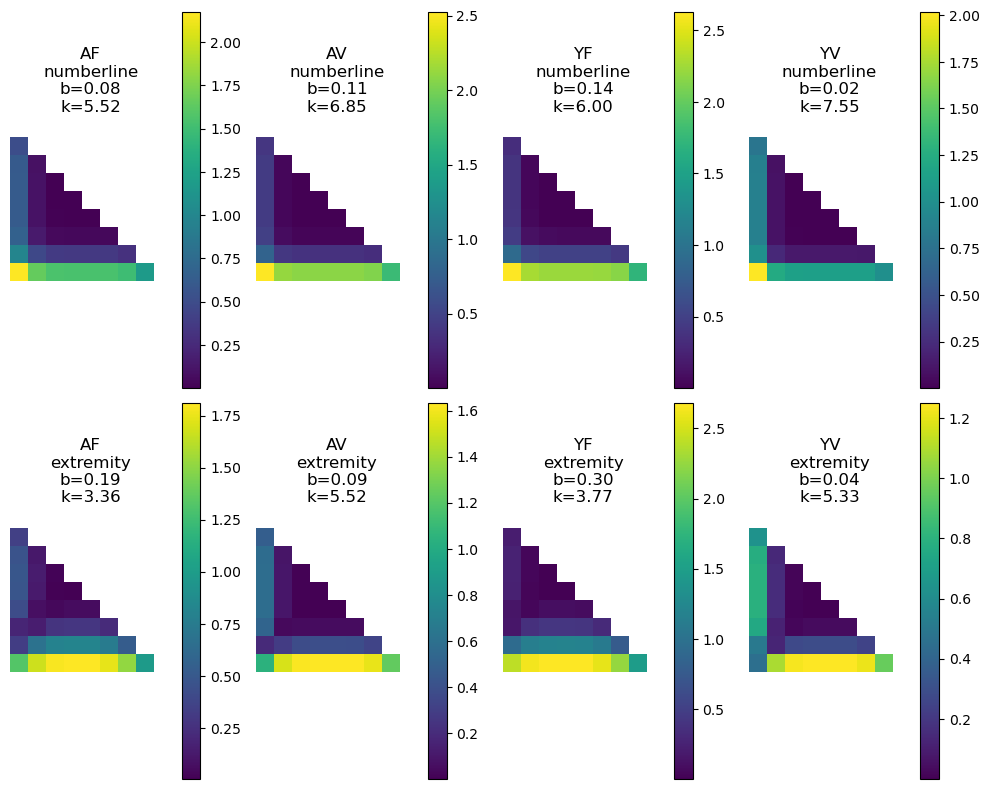

In [236]:
highest_mean_params_copy = dict(highest_mean_params)
del highest_mean_params_copy["both"]

fig, axs = plt.subplots(
    len(highest_mean_params_copy.keys()),
    len(highest_mean_params_copy[list(highest_mean_params_copy.keys())[0]].values()),
    figsize=(10, 8),
)

for imodel, model_to_use in enumerate(highest_mean_params_copy):

    combis_to_plot = list(highest_mean_params_copy[model_to_use].values())
    _model_rdms = produce_model_rdms(model_to_use, combis_to_plot)

    # Plot model-RDMs
    # ---------------
    for i, ax in enumerate(axs[imodel, :].flat):

        _to_plot = _model_rdms[..., i].copy()

        # Remove upper triangle
        tri_idx = np.triu_indices(_to_plot.shape[0])
        _to_plot[tri_idx] = np.nan

        im = ax.imshow(_to_plot)

        fig.colorbar(im, ax=ax)
        ax.axis("off")

        bias, kappa = combis_to_plot[i]
        ax.set(
            title=f"{(list(tasks)*2)[i]}\n{model_to_use}\nb={bias:.2f}\nk={kappa:.2f}"
        )

fig.tight_layout()

if plotsave:
    fpath = os.path.join(plotsavedir, "neurometric_best_models.pdf")
    fig.savefig(fpath, bbox_inches="tight")

## Plot 2x2 parameters

In [237]:
# Collect subject wide maxima for bias and kappa ... for each "model"
dfs = []
for model_to_use in ["numberline", "extremity", "both"]:
    (
        coef_map,
        pval_map_subjs,
        tval_map,
        pval_map,
        subj_maxima,
        wilcoxon,
    ) = neurometrics_data[model_to_use]

    _dfs = []
    for itask, task in enumerate(tasks):
        data = {}

        subj_idxs = np.unique(df[df["task"] == task]["subject"]) - 1
        param_idxs = subj_maxima[subj_idxs, itask, ...][:, 0:2]

        data["kappa"] = kappas[param_idxs[:, 0].astype(int)]
        data["bias"] = biases[param_idxs[:, 1].astype(int)]
        data["subject"] = subj_idxs + 1

        _df = pd.DataFrame(data)
        _df["task"] = task
        _dfs.append(_df)

    _df = pd.concat(_dfs)[["subject", "task", "bias", "kappa"]]
    _df["sampling"] = _df["task"].str[0].map({"A": "active", "Y": "yoked"})
    _df["stopping"] = _df["task"].str[1].map({"V": "variable", "F": "fixed"})
    _df["model"] = model_to_use

    assert not _df.isna().any().any()

    dfs.append(_df)

_df = pd.concat(dfs)

In [238]:
def plt_single_subj(ax):
    subj_line_settings = dict(color="black", alpha=0.1, linewidth=0.75)
    _idxs_to_pick = [(2, 4), (3, 5)]
    for idx0, idx1 in _idxs_to_pick:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, **subj_line_settings)

In [239]:
models_to_use = ["numberline", "extremity", "both"]
fig, axs = plt.subplots(
    len(models_to_use), 2, figsize=(10, 15), sharex=True, sharey=False
)

for imodel, model_to_use in enumerate(models_to_use):

    ax1, ax2 = axs[imodel, :]

    _data = _df[_df["model"] == model_to_use]

    kwargs = dict(
        dodge=True,
        data=_data,
        x="sampling",
        hue="stopping",
        order=["active", "yoked"],
        hue_order=["fixed", "variable"],
    )

    sns.pointplot(y="bias", ax=ax1, ci=68, **kwargs)
    sns.swarmplot(y="bias", ax=ax1, **kwargs, size=3)

    plt_single_subj(ax1)

    sns.pointplot(y="kappa", ax=ax2, ci=68, **kwargs)
    sns.stripplot(y="kappa", ax=ax2, **kwargs, size=3)

    plt_single_subj(ax2)

    ax1.axhline(0, color="black", linestyle="--")
    ax2.axhline(1, color="black", linestyle="--")

    ax1.set(
        xticklabels=["self-\ncontrolled", "yoked"],
        ylim=(-1.1, 1.1),
        title=model_to_use + " (bias)",
    )
    ax2.set(title=model_to_use + " (kappa)")

    ax2.get_legend().remove()
    if imodel == 0:
        handles, labels = ax1.get_legend_handles_labels()
        leg = ax1.legend(
            handles[0:2],
            [{"fixed": "partial", "variable": "full"}[i] for i in labels[0:2]],
            ncol=2,
            bbox_to_anchor=(0.25, 0.96),
            bbox_transform=fig.transFigure,
        )
    else:
        ax1.get_legend().remove()


fig.tight_layout()

if plotsave:
    fpath = os.path.join(plotsavedir, "neurometric_2x2.pdf")
    fig.savefig(fpath, bbox_inches="tight", bbox_extra_artists=[leg])

In [240]:
# Calculate mixed ANOVAs for the 2x2 params, and save the tables as HTML file

if plotsave:

    with open(os.path.join(plotsavedir, "neurometric_2x2_stats.html"), "w") as fout:

        for param in ["bias", "kappa"]:
            print("<p></p>" + param + "<p></p>", file=fout)

            for model_to_use in models_to_use:
                _data = _df[_df["model"] == model_to_use]
                stats = pingouin.mixed_anova(
                    data=_data,
                    dv=param,
                    within="sampling",
                    between="stopping",
                    subject="subject",
                )

                to_write = stats.to_html()

                print(model_to_use, file=fout)
                print(to_write, file=fout)

## Plot neurometric function over rescaled numbers

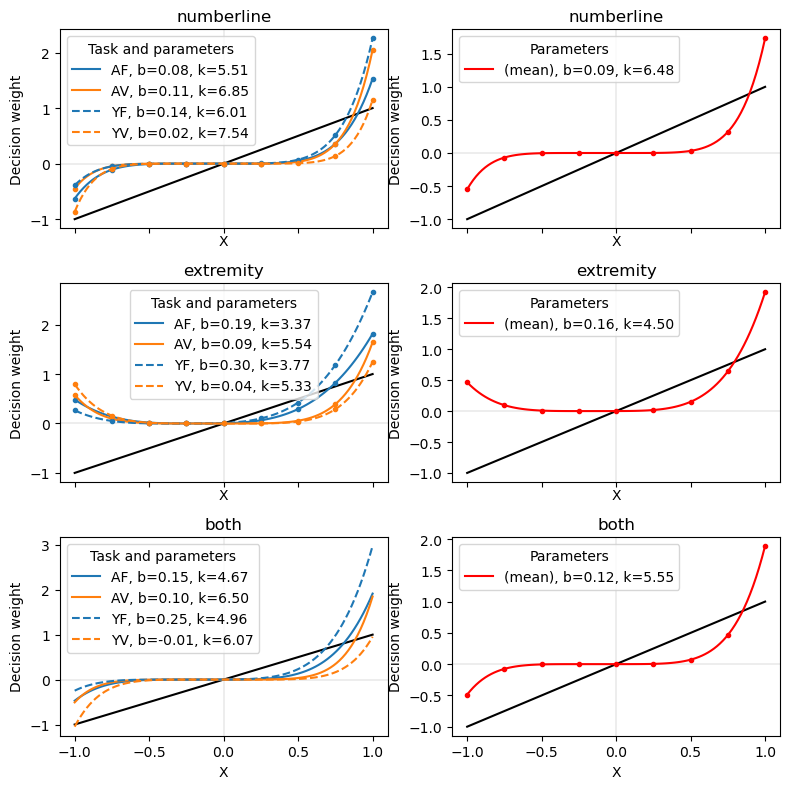

In [241]:
fig, axs = plt.subplots(
    len(models_to_use), 2, figsize=(8, 8), sharex=True, sharey=False
)

n_points_X = 100

for imodel, model_to_use in enumerate(models_to_use):

    ax1, ax2 = axs[imodel, :]

    _data = _df[_df["model"] == model_to_use]

    ax1.plot(np.linspace(-1, 1, 3), np.linspace(-1, 1, 3), "k-")
    ax1.axhline(0, color="black", linewidth=0.1)
    ax1.axvline(0, color="black", linewidth=0.1)

    # Plot task-wise data
    for task, grp in _data.groupby("task"):

        linestyle = "--" if "Y" in task else "-"
        color = sns.color_palette()[0] if "F" in task else sns.color_palette()[1]

        bias = grp.mean()["bias"]
        kappa = grp.mean()["kappa"]
        values = eq1(
            np.linspace(-1, 1, n_points_X),
            bias=bias,
            kappa=kappa,
        )

        if model_to_use == "extremity":
            values = np.abs(values)
        else:
            assert model_to_use in ["numberline", "both"]

        ax1.plot(
            np.linspace(-1, 1, n_points_X),
            values,
            label=f"{task}, b={bias:.2f}, k={kappa:.2f}",
            color=color,
            linestyle=linestyle,
        )

        if model_to_use != "both":
            # plot the "markers" on top of the lines
            values = eq1(
                numbers_rescaled,
                bias=bias,
                kappa=kappa,
            )

            if model_to_use == "extremity":
                values = np.abs(values)

            ax1.plot(
                numbers_rescaled,
                values,
                color=color,
                marker="o",
                linestyle="",
                markersize=3,
            )

    # plot summarized over tasks
    bias = _data.mean()["bias"]
    kappa = _data.mean()["kappa"]
    values = eq1(
        np.linspace(-1, 1, n_points_X),
        bias=bias,
        kappa=kappa,
    )

    if model_to_use == "extremity":
        values = np.abs(values)

    ax2.plot(np.linspace(-1, 1, 3), np.linspace(-1, 1, 3), "k-")
    ax2.axhline(0, color="black", linewidth=0.1)
    ax2.axvline(0, color="black", linewidth=0.1)

    ax2.plot(
        np.linspace(-1, 1, n_points_X),
        values,
        "r-",
        label=f"(mean), b={bias:.2f}, k={kappa:.2f}",
    )

    # plot the "markers" on top of the lines
    values = eq1(
        numbers_rescaled,
        bias=bias,
        kappa=kappa,
    )

    if model_to_use == "extremity":
        values = np.abs(values)        

    ax2.plot(
        numbers_rescaled,
        values,
        "ro",
        linestyle="",
        markersize=3,
    )

    # Tweaks
    # ------
    ax1.legend(title="Task and parameters")
    ax2.legend(title="Parameters")
    ax1.set(
        title=model_to_use,
        xlabel="X",
        ylabel="Decision weight",
    )
    ax2.set(
        title=model_to_use,
        xlabel="X",
        ylabel="Decision weight",
    )


fig.tight_layout()

if plotsave:
    fpath = os.path.join(plotsavedir, "neurometric_curves.pdf")
    fig.savefig(fpath, bbox_inches="tight")

## plot model RDMs

In [242]:
model_to_use = "extremity"

combis_to_plot = list(
    itertools.product(np.linspace(-1, 1, 3), np.linspace(0.5, 2.5, 5))
)
ncombis = len(combis_to_plot)

_model_rdms = produce_model_rdms(model_to_use, combis_to_plot)

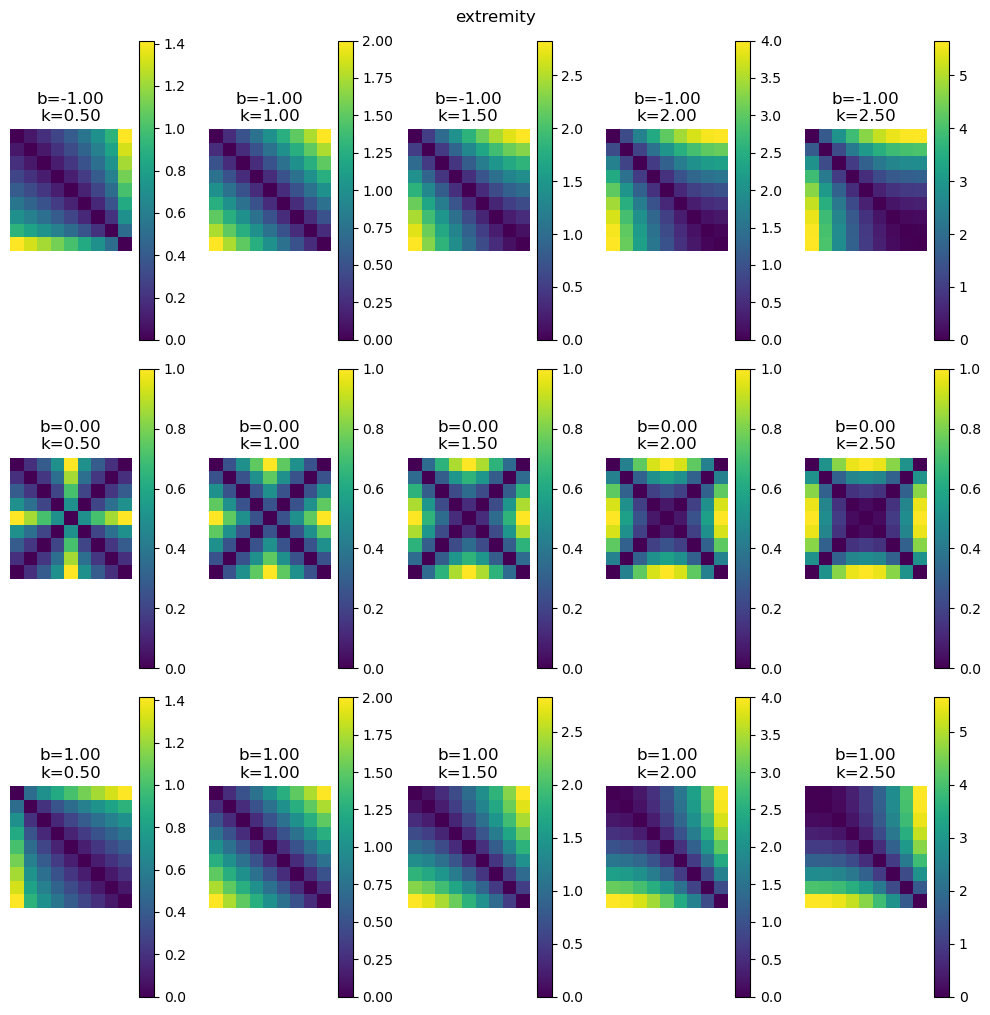

In [243]:
# Plot model-RDMs
# ---------------
fig, axs = plt.subplots(
    len(np.unique(np.array(combis_to_plot)[:, 0])),
    len(np.unique(np.array(combis_to_plot)[:, 1])),
    figsize=(10, 10),
)

for i, ax in enumerate(axs.flat):

    try:
        im = ax.imshow(_model_rdms[..., i])
    except IndexError:
        ax.axis("off")
        continue

    fig.colorbar(im, ax=ax)
    ax.axis("off")

    bias, kappa = combis_to_plot[i]
    ax.set(title=f"b={bias:.2f}\nk={kappa:.2f}")


fig.tight_layout()
suptitle = fig.suptitle(model_to_use, y=1.01)

## Explore Eq1 (kappa & bias)

notes for numberline:

decision weight: distance to zero

- Kappa is the compression parameter
    - if 1: linear
    - if < 1: compression: outliers are "compressed, relative to "inliers"
    - if > 1: anti-compression: opposite of compression
    - always with respect to the midpoint of the scale (0)
- Bias is an offset parameter
    - can move the "inflection point" of the decision weights to the left or right of the scale
    - bias 0: inflection point is at the midpoint of the scale
    - bias > 1: inflection point moves left, high `X` gain more weight then low `X`
    - bias < 1: inflection point moves right, low `X` gain more weight then high `X`
    
    
kappa and bias together inform about the point of "highest sensitivity" (where the slope / rate of change is highest)

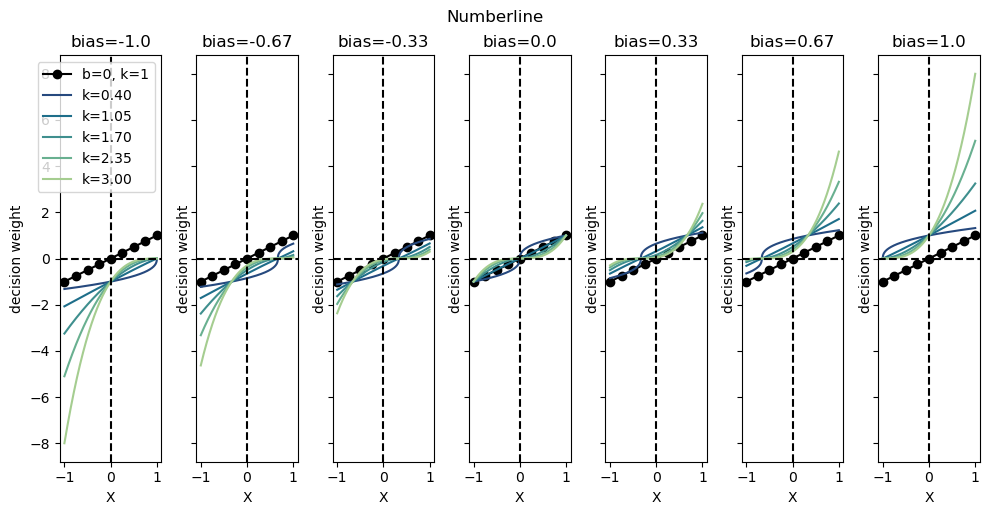

In [216]:
# numberline
cmap = sns.color_palette("crest_r", as_cmap=True)

bs = np.linspace(-1, 1, 7)
ks = np.linspace(0.4, 3, 5)

fig, axs = plt.subplots(1, len(bs), figsize=(10, 5), sharex=True, sharey=True)
for i, b in enumerate(bs):
    ax = axs.flat[i]
    ax.plot(
        np.linspace(-1, 1, 9),
        eq1(numbers_rescaled, bias=0, kappa=1),
        color="k",
        marker="o",
        label="b=0, k=1",
    )
    ax.set(title=f"bias={b:.2}", ylabel="decision weight", xlabel="X")

    for k in ks:
        ax.plot(
            np.linspace(-1, 1, 1000),
            eq1(np.linspace(-1, 1, 1000), b, k),
            color=cmap(k / ks.max()),
            label=f"k={k:.2f}",
        )

    ax.axhline(0, color="k", linestyle="--")
    ax.axvline(0, color="k", linestyle="--")
    if i == 0:
        ax.legend()

fig.suptitle("Numberline", y=1.02)
fig.tight_layout()

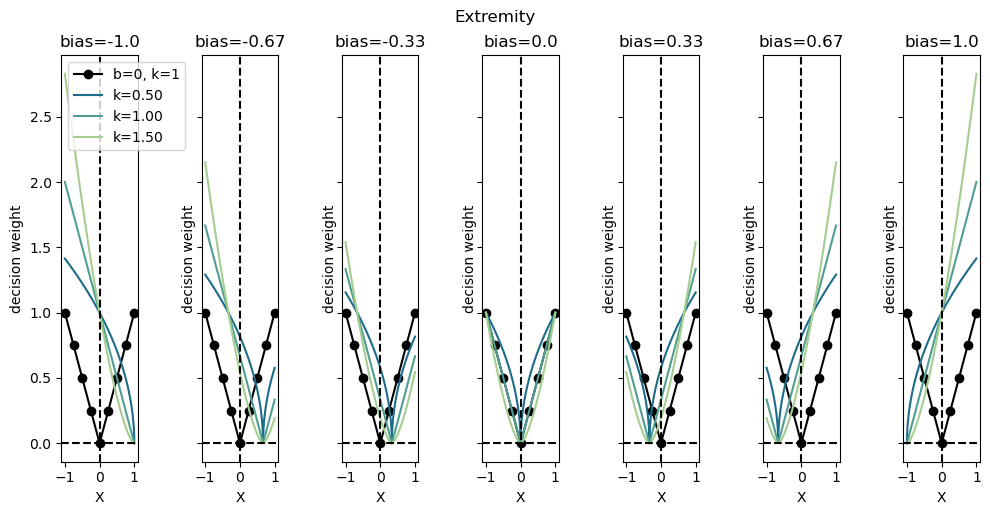

In [217]:
# extremity
cmap = sns.color_palette("crest_r", as_cmap=True)

bs = np.linspace(-1, 1, 7)
ks = np.array([0.5, 1, 1.5])

fig, axs = plt.subplots(1, len(bs), figsize=(10, 5), sharex=True, sharey=True)
for i, b in enumerate(bs):
    ax = axs.flat[i]
    ax.plot(
        np.linspace(-1, 1, 9),
        np.abs(eq1(numbers_rescaled, bias=0, kappa=1)),  # NOTE: np.abs !
        color="k",
        marker="o",
        label="b=0, k=1",
    )
    ax.set(title=f"bias={b:.2}", ylabel="decision weight", xlabel="X")

    for k in ks:
        ax.plot(
            np.linspace(-1, 1, 1000),
            np.abs(eq1(np.linspace(-1, 1, 1000), b, k)),  # NOTE: np.abs !
            color=cmap(k / ks.max()),
            label=f"k={k:.2f}",
        )

    ax.axhline(0, color="k", linestyle="--")
    ax.axvline(0, color="k", linestyle="--")
    if i == 0:
        ax.legend()

fig.suptitle("Extremity", y=1.02)
fig.tight_layout()